# Testing the sensitivity of percision to threshold setting #

Using the vaidation data, test how different thresholds change model precision.

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import seaborn as sns

# Load Classified Data #
Data is split between two files: 
- `test-xception-57-class-non-merge.csv` - contains all of the probabilities for each class for each images
- `test-xception-57-fnames-non-merge-altered.csv` - image filenames and the manually annoated class

To get at accuracy, these dataframes need to be merged

In [18]:
df = pd.read_csv("../output/test-xception-57-class-non-merge.csv", index_col=0)
cols = df.columns
fnames = pd.read_csv("../output/test-xception-57-fnames-non-merge-altered.csv")
df['fname'] = fnames['fname']
df['base'] = fnames['base']
df['class_name'] = fnames['class']

Helper functions to combine the dataframes

In [19]:
def get_top_prob(row):
    return row[cols].max()

def get_top_class(row):
    ix = row[cols].values.argmax()
    return cols[ix]

In [20]:
df['top_prob'] = df.apply(get_top_prob,axis=1)
df['top_class'] = df.apply(get_top_class,axis=1)
df.head()

Akashiwo  Alexandrium_singlet  Amy_Gony_Protoc    Ash_glassy  \
0  4.092260e-04         2.906429e-03     1.605081e-03  5.499870e-05   
1  6.314614e-13         8.991906e-10     1.628172e-15  1.673903e-19   
2  2.736630e-02         5.134355e-04     1.254932e-09  5.097831e-12   
3  3.584643e-05         1.384842e-02     4.537459e-04  5.228111e-08   
4  7.385238e-11         5.544755e-11     4.002949e-15  4.552701e-14   

   Asterionellopsis  Bacteriastrum         Beads   Boreadinium       Centric  \
0      1.979580e-06   2.420462e-03  1.391555e-06  5.939455e-05  4.665339e-01   
1      1.333142e-13   5.886286e-16  1.162385e-17  5.530419e-10  2.502345e-06   
2      4.328355e-12   7.794615e-06  1.684689e-14  1.161901e-04  6.893170e-02   
3      1.931874e-08   2.448675e-06  1.232731e-18  5.951484e-05  1.406969e-04   
4      2.000081e-22   5.509312e-15  1.917551e-26  1.317317e-10  1.109820e-08   

       Ceratium  ...      Tontonia    Torodinium   Tropidoneis     Vicicitus  \
0  1.531286e-07  ...  4.182042e-07  1.006070e-03  1.497798e-04  1.416002e-04   
1  6.404153e-13  ...  6.358144e-14  7.209127e-12  4.885677e-12  1.144491e-16   
2  1.614456e-10  ...  1.633676e-07  4.172640e-09  2.195073e-08  1.408168e-08   
3  2.413013e-05  ...  4.699619e-05  2.285038e-08  2.661285e-11  4.438715e-05   
4  4.371093e-16  ...  3.040349e-16  2.002875e-15  3.030300e-15  9.225258e-18   

       cyst                                              fname  \
0  0.016897  /hb/home/pcdaniel/ifcb-training/training-sorte...   
1  0.999993  /hb/home/pcdaniel/ifcb-training/training-sorte...   
2  0.895496  /hb/home/pcdaniel/ifcb-training/training-sorte...   
3  0.982809  /hb/home/pcdaniel/ifcb-training/training-sorte...   
4  1.000000  /hb/home/pcdaniel/ifcb-training/training-sorte...   

                                 base  class_name  top_prob  top_class  
0  D20180707T054031_IFCB104_00388.png        cyst  0.466534    Centric  
1  D20181005T071250_IFCB104_00114.png        cyst  0.999993       cyst  
2  D20200526T091230_IFCB104_02336.png        cyst  0.895496       cyst  
3  D20200527T044631_IFCB104_02401.png        cyst  0.982809       cyst  
4  D20200527T053317_IFCB104_03161.png        cyst  1.000000       cyst  

[5 rows x 62 columns]

__Ramp threshold from (.01 to .99) and recalculate accuracy at each step__

In [52]:
class_val = df['class_name'].values
class_top = df['top_class'].values
class_prob = df['top_prob'].values
thresh = np.arange(.0,1,0.01)
class_acc_all = np.zeros(len(thresh))
class_f = np.zeros(len(thresh))

In [54]:
for i, t in enumerate(thresh):
    new_class = np.copy(class_top)
    ixs = np.where(class_prob < t)
    new_class[ixs] = 'Unknown'
    class_acc_all[i] = sklearn.metrics.accuracy_score(class_val, new_class,normalize=True)
    class_f[i] = sklearn.metrics.f1_score(class_val, new_class, average="weighted")

__Plot Results__

In [74]:
sns.set_context("notebook")

fig, (ax, ax2) = plt.subplots(2)
fig.set_size_inches(6,8)
ax.scatter(thresh, class_acc_all)
ax.set_xlabel("Threshold")
ax.set_ylabel("Accuracy")
ax.set_ylim(.6,1)

ax2.scatter(thresh, class_f)
ax2.set_xlabel("Threshold")
ax2.set_ylabel("f1-score")
ax2.set_ylim(.6,1)
sns.despine()
plt.savefig("../notebooks/figures/threshold_sensitivity_all.png", dpi=300, bbox_inches='tight')

## Calculate accuracy for each class ##

Store data in `class_acc` which should (57 x 100)

In [56]:

thresh = np.arange(.0,1,0.01)
class_acc = np.zeros((cols.shape[0],len(thresh))) # 57 x 100

for j, c in enumerate(cols):
    class_df = df.query("class_name == @c")
    class_val = class_df['class_name'].values
    class_top = class_df['top_class'].values
    class_prob = class_df['top_prob'].values
    for i, t in enumerate(thresh):
        new_class = np.copy(class_top)
        ixs = np.where(class_prob < t)
        new_class[ixs] = 'Unknown'
        class_acc[j,i] = sklearn.metrics.accuracy_score(class_val, new_class,normalize=True)

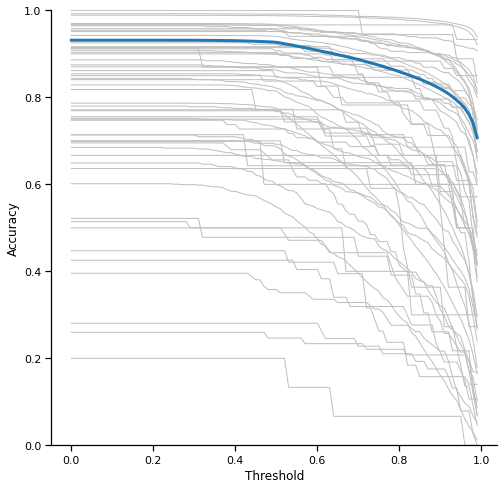

In [67]:
sns.set_context("notebook")

fig, ax = plt.subplots()
fig.set_size_inches(8,8)
for k in range(cols.shape[0]):
    ax.plot(thresh, class_acc[k,:],color='.75',marker='None',lw=1)

ax.plot(thresh, class_acc_all, marker='None',lw=3)
ax.set_xlabel("Threshold")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,1)

sns.despine()
plt.savefig("../notebooks/figures/threshold_sensitivity_byclass.png", dpi=300, bbox_inches='tight')

In [70]:
!pwd

/Users/patrick/OneDrive/UCSC/IFCB/ifcb-training/notebooks
